In [1]:
%%capture
!python -m pip install --upgrade pip
!pip install pytorch_lightning
!pip install --upgrade torch torchvision torchaudio
!pip install matplotlib

Seed set to 42


Training Diffusion Model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 13.9 M | train
---------------------------------------
13.9 M    Trainable params
0         Non-trainable params
13.9 M    Total params
55.634    Total estimated model params size (MB)
165       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lightning_logs/version_9/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | SimpleClassifier | 155 K  | train
---------------------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.622     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Training Classifier on Noisy Images...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/opt/conda/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-hpenmny9'


Performing Guided Sampling...


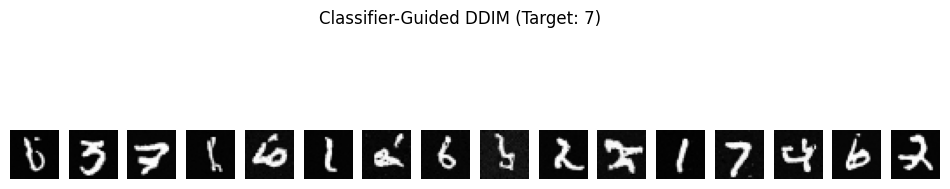

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(32, in_channels)
        self.norm2 = nn.GroupNorm(32, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        t_emb = self.time_mlp(t)[:, :, None, None]
        h = h + t_emb
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(32, channels)
        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(b, c, -1).permute(0, 2, 1)
        k = self.k(x_norm).reshape(b, c, -1)
        v = self.v(x_norm).reshape(b, c, -1).permute(0, 2, 1)
        attn = torch.bmm(q, k) * (c ** -0.5)
        attn = torch.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(b, c, h, w)
        return x + self.proj_out(out)

class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(channels, channels, kernel_size=4, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_res_blocks, use_attn=False):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels if i == 0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_res_blocks)
        ])
        self.use_attn = use_attn
        if use_attn:
            self.attn = AttentionBlock(out_channels)
        self.downsample = Downsample(out_channels)
    def forward(self, x, t):
        skip_connections = []
        for block in self.res_blocks:
            x = block(x, t)
            skip_connections.append(x)
        if self.use_attn:
            x = self.attn(x)
        x_down = self.downsample(x)
        return x_down, skip_connections

def center_crop(x, target_shape):
    _, _, h, w = x.shape
    th, tw = target_shape
    start_h = (h - th) // 2
    start_w = (w - tw) // 2
    return x[:, :, start_h:start_h+th, start_w:start_w+tw]

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_res_blocks, use_attn=False):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels + out_channels if i == 0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_res_blocks)
        ])
        self.use_attn = use_attn
        if use_attn:
            self.attn = AttentionBlock(out_channels)
    def forward(self, x, skip_connections, t):
        x = self.upsample(x)
        skip = skip_connections.pop()
        if x.shape[2:] != skip.shape[2:]:
            x = center_crop(x, skip.shape[2:])
        x = torch.cat([x, skip], dim=1)
        for block in self.res_blocks:
            x = block(x, t)
        if self.use_attn:
            x = self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=64,
                 channel_mults=(1, 2, 4), num_res_blocks=2, time_emb_dim=256,
                 attn_resolutions=None):
        super().__init__()
        if attn_resolutions is None:
            attn_resolutions = []
        self.time_embedding = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.down_blocks = nn.ModuleList()
        in_ch = base_channels
        for i, mult in enumerate(channel_mults):
            out_ch = base_channels * mult
            use_attn = (i in attn_resolutions)
            self.down_blocks.append(DownBlock(in_ch, out_ch, time_emb_dim, num_res_blocks, use_attn))
            in_ch = out_ch
        self.mid_block1 = ResBlock(in_ch, in_ch, time_emb_dim)
        self.mid_attn = AttentionBlock(in_ch)
        self.mid_block2 = ResBlock(in_ch, in_ch, time_emb_dim)
        self.up_blocks = nn.ModuleList()
        for i, mult in enumerate(reversed(channel_mults)):
            out_ch = base_channels * mult
            use_attn = ((len(channel_mults) - 1 - i) in attn_resolutions)
            self.up_blocks.append(UpBlock(in_ch, out_ch, time_emb_dim, num_res_blocks, use_attn))
            in_ch = out_ch
        self.final_norm = nn.GroupNorm(32, in_ch)
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(in_ch, out_channels, kernel_size=3, padding=1)
    def forward(self, x, t):
        t = t.to(x.device)
        t_emb = self.time_embedding(t)
        x = self.initial_conv(x)
        skip_connections_all = []
        for block in self.down_blocks:
            x, skip_connections = block(x, t_emb)
            skip_connections_all.append(skip_connections)
        x = self.mid_block1(x, t_emb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_emb)
        for block in self.up_blocks:
            skip_connections = skip_connections_all.pop()
            x = block(x, skip_connections, t_emb)
        x = self.final_norm(x)
        x = self.final_act(x)
        return self.final_conv(x)


class DiffusionModelPL(pl.LightningModule):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02, lr=1e-3):
        super().__init__()
        self.model = model
        self.T = T
        self.lr = lr
        beta = torch.linspace(beta_start, beta_end, T)
        alpha = 1.0 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        self.register_buffer("beta", beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_bar", alpha_bar)
        self.register_buffer("sqrt_alpha_bar", torch.sqrt(alpha_bar))
        self.register_buffer("sqrt_one_minus_alpha_bar", torch.sqrt(1 - alpha_bar))
    def forward(self, x, t):
        # t is expected as a float tensor of shape (B,)
        return self.model(x, t)
    def training_step(self, batch, batch_idx):
        x, _ = batch  # x in [0,1]
        B = x.size(0)
        # Sample a random timestep for each image.
        t = torch.randint(0, self.T, (B,), device=x.device, dtype=torch.long)
        # Get corresponding schedule values.
        sqrt_alpha_bar_t = self.sqrt_alpha_bar[t].view(B, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[t].view(B, 1, 1, 1)
        noise = torch.randn_like(x)
        x_t = sqrt_alpha_bar_t * x + sqrt_one_minus_alpha_bar_t * noise
        # Pass t as float.
        t_float = t.float()
        pred_noise = self(x_t, t_float)
        loss = F.mse_loss(pred_noise, noise)
        self.log("train_loss", loss)
        return loss
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)


class SimpleClassifier(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 7 * 7, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

class ClassifierPL(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        images, labels = batch
        B = images.size(0)
        device = images.device
        x0 = torch.randn_like(images, device=device)
        t = torch.rand(B, device=device)
        t_expanded = t.view(B, 1, 1, 1)
        x_noisy = (1 - t_expanded) * x0 + t_expanded * images
        logits = self(x_noisy)
        loss = F.cross_entropy(logits, labels)
        self.log("train_loss", loss)
        return loss
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        B = images.size(0)
        device = images.device
        x0 = torch.randn_like(images, device=device)
        t = torch.rand(B, device=device)
        t_expanded = t.view(B, 1, 1, 1)
        x_noisy = (1 - t_expanded) * x0 + t_expanded * images
        logits = self(x_noisy)
        loss = F.cross_entropy(logits, labels)
        acc = (logits.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc)
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)


def guided_ddim_sample(diffusion_model, classifier, target_class, num_steps=50, guidance_scale=2.0, batch_size=16, shape=(1,28,28)):
    device = next(diffusion_model.parameters()).device
    T = diffusion_model.T
    timesteps = torch.linspace(0, T-1, num_steps, device=device, dtype=torch.long)
    x = torch.randn(batch_size, *shape, device=device)
    for i in reversed(range(num_steps)):
        t = timesteps[i]
        B = x.size(0)
        sqrt_alpha_bar_t = diffusion_model.sqrt_alpha_bar[t].view(1,1,1,1)
        sqrt_one_minus_alpha_bar_t = diffusion_model.sqrt_one_minus_alpha_bar[t].view(1,1,1,1)
        t_batch = torch.full((B,), float(t), device=device)
        epsilon_pred = diffusion_model(x, t_batch)
        x0_pred = (x - sqrt_one_minus_alpha_bar_t * epsilon_pred) / sqrt_alpha_bar_t
        x.requires_grad_(True)
        logits = classifier(x)
        log_probs = F.log_softmax(logits, dim=1)
        target_log_prob = log_probs[:, target_class].sum()
        grad_classifier = torch.autograd.grad(target_log_prob, x)[0]
        x0_pred = x0_pred + guidance_scale * grad_classifier
        epsilon_pred = (x - sqrt_alpha_bar_t * x0_pred) / sqrt_one_minus_alpha_bar_t
        if i > 0:
            t_prev = timesteps[i-1]
            sqrt_alpha_bar_t_prev = diffusion_model.sqrt_alpha_bar[t_prev].view(1,1,1,1)
            sqrt_one_minus_alpha_bar_t_prev = diffusion_model.sqrt_one_minus_alpha_bar[t_prev].view(1,1,1,1)
            x = sqrt_alpha_bar_t_prev * x0_pred + sqrt_one_minus_alpha_bar_t_prev * epsilon_pred
        else:
            x = x0_pred
        x = x.detach()
    return x


def visualize_images(images, title=""):
    images = images.cpu().detach()
    num_samples = images.size(0)
    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


pl.seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="data", train=True, download=True, transform=transform)
mnist_val = datasets.MNIST(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=4)

print("Training Diffusion Model...")
unet_model = UNet(in_channels=1, out_channels=1, base_channels=64,
                  channel_mults=(1,2,4), num_res_blocks=2, time_emb_dim=256,
                  attn_resolutions=[])  
diffusion_pl = DiffusionModelPL(unet_model, T=1000, lr=1e-3)
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
trainer.fit(diffusion_pl, train_loader, val_loader)
torch.save(diffusion_pl.state_dict(), "ddpm_mnist.pth")

print("Training Classifier on Noisy Images...")
classifier_model = SimpleClassifier(in_channels=1, num_classes=10)
classifier_pl = ClassifierPL(classifier_model, lr=1e-3)
trainer.fit(classifier_pl, train_loader, val_loader)
torch.save(classifier_model.state_dict(), "classifier_noisy_mnist.pth")

diffusion_pl.eval()
classifier_model.eval()

print("Performing Guided Sampling...")
num_samples = 16
guided_images = guided_ddim_sample(diffusion_pl, classifier_model, target_class=7,
                                   num_steps=50, guidance_scale=2.0, batch_size=num_samples, shape=(1,28,28))
visualize_images(guided_images, title="Classifier-Guided DDIM (Target: 7)")
